# **Analysis of decoding results**

## **Libraries**

In [1]:
#%pip install pandas matplotlib seaborn nltk sacrebleu

In [2]:
import os
import warnings

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import nltk
import sacrebleu

import constants

## **Directories**

In [3]:
RESULTS_FOLDER = constants.RESULTS_DATA_FOLDER
INSPECTED_FOLDER = constants.INSPECTED_DATA_FOLDER

DECODED_OUTPUTS_FILENAME = 'split_decode_checkpoint_100-80.log'#'first_decode_checkpoint_100-50.log'#
DECODED_OUTPUTS_FILEPATH = os.path.join(INSPECTED_FOLDER, DECODED_OUTPUTS_FILENAME)
REFERENCE_SOURCE_FILENAME = 'first_val_gn.txt'#
REFERENCE_SOURCE_FILEPATH = os.path.join(INSPECTED_FOLDER, REFERENCE_SOURCE_FILENAME)
REFERENCE_DESTINATION_FILENAME = 'first_val_es.txt'#
REFERENCE_DESTINATION_FILEPATH = os.path.join(INSPECTED_FOLDER, REFERENCE_DESTINATION_FILENAME)
FIRST_DECODING_RESULTS_FOLDER = os.path.join(RESULTS_FOLDER, 'first_decode_checkpoint_100-50')
CURRENT_RESULTS_FOLDER = os.path.join(FIRST_DECODING_RESULTS_FOLDER, DECODED_OUTPUTS_FILENAME.split('.')[0])

if not os.path.exists(FIRST_DECODING_RESULTS_FOLDER):
    os.makedirs(FIRST_DECODING_RESULTS_FOLDER)

if not os.path.exists(CURRENT_RESULTS_FOLDER):
    os.makedirs(CURRENT_RESULTS_FOLDER)

In [4]:
with open(REFERENCE_SOURCE_FILEPATH, 'r', encoding='utf-8') as f:
    reference_source_gn = f.readlines()

with open(REFERENCE_DESTINATION_FILEPATH, 'r', encoding='utf-8') as f:
    reference_destination_es = f.readlines()

with open(DECODED_OUTPUTS_FILEPATH, 'r', encoding='utf-8') as f:
    decoded_outputs = f.readlines()

## **Checking files**

In [5]:
print(f'Number of lines in reference source: {len(reference_source_gn)}')
print(f'Number of lines in reference destination: {len(reference_destination_es)}')
print(f'Number of lines in decoded outputs: {len(decoded_outputs)}')

Number of lines in reference source: 4939
Number of lines in reference destination: 4939
Number of lines in decoded outputs: 5309


There is a difference of 1 between the number of lines in the decoded outputs and the number of lines in the original inputs.

In [6]:
for idx, (elem_ref, elem_dest, decoded) in enumerate(zip(reference_source_gn, reference_destination_es, decoded_outputs)):
    if elem_ref.strip() == '':
        print(f'Empty line at index {idx} from reference source')

    if elem_dest.strip() == '':
        print(f'Empty line at index {idx} from reference destination')

    if decoded.strip() == '':
        print(f'Empty line at index {idx} from decoded outputs')

This extra line is not a problem, as the decoded file can output empty lines. However, it remains unclear why the length of the files are different.

## **Score analysis**

### **Examples of BLEU score**

In [7]:
def silence_warnings(func):
    def wrapper(*args, **kwargs):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            return func(*args, **kwargs)
    return wrapper

In [8]:
correct_reference = ['Today', 'is', 'a', 'new', 'day']
short_reference = ['Today']
wrong_reference = ['Yesterday', 'was', 'a', 'good', 'day']

translated = ['Today', 'is', 'a', 'new', 'day']

### **Classic BLEU**

In [9]:
@silence_warnings
def calculate_bleu(reference, translated, bleu_score_type='classic'):
    classic_bleu_function = lambda reference, translated: nltk.translate.bleu_score.sentence_bleu([reference], translated)
    chrf_function = lambda reference, translated: sacrebleu.corpus_chrf(translated, [reference]).score
    sacrebleu_function = lambda reference, translated: sacrebleu.corpus_bleu([' '.join(translated)], [[' '.join(reference)]]).score
    
    score_functions = {
        'classic': classic_bleu_function,
        'chrf': chrf_function,
        'sacrebleu': sacrebleu_function
    }

    bleu_score = score_functions[bleu_score_type](reference, translated)
    return bleu_score

In [10]:
def create_bleu_scores_df(references, translated, bleu_score_types):
    bleu_scores_df = {'reference': [], 'translation': [], 'metric': [], 'score': []}

    for reference, translation in zip(references, translated):
        for bleu_score_type in bleu_score_types:
            bleu_score = calculate_bleu(reference, translation, bleu_score_type=bleu_score_type)
            bleu_scores_df['reference'].append(' '.join(reference))
            bleu_scores_df['translation'].append(' '.join(translation))
            bleu_scores_df['metric'].append(bleu_score_type)
            bleu_scores_df['score'].append(bleu_score)

    return pd.DataFrame(bleu_scores_df)

#### **Test examples**

In [11]:
example_dfs = []

example_references = [correct_reference, short_reference, wrong_reference]
bleu_scores_example_df = create_bleu_scores_df(
    example_references, 
    [translated]*len(example_references), 
    bleu_score_types=['classic', 'chrf', 'sacrebleu']
)
example_dfs.append(bleu_scores_example_df)

example_dfs = pd.concat(example_dfs)
example_dfs.style.format({'score': '{:.5g}'})

,reference,translation,metric,score
0,Today is a new day,Today is a new day,classic,1
1,Today is a new day,Today is a new day,chrf,100
2,Today is a new day,Today is a new day,sacrebleu,100
3,Today,Today is a new day,classic,1.2183e-231
4,Today,Today is a new day,chrf,100
5,Today,Today is a new day,sacrebleu,10.682
6,Yesterday was a good day,Today is a new day,classic,1.4488e-231
7,Yesterday was a good day,Today is a new day,chrf,18.448
8,Yesterday was a good day,Today is a new day,sacrebleu,12.703


In [12]:
#calculate chrf score
def calculate_chrf(reference, translated):
    chrf_score = sacrebleu.corpus_chrf(translated, [reference]).score
    return chrf_score

reference = ['Today', 'is', 'a', 'ne', 'day']
translated = ['Today', 'is', 'a', 'new', 'day']

chrf_score = calculate_chrf(reference, translated)
print(f'CHRF score: {chrf_score}')

CHRF score: 99.24787442773054


### **BLEU score distribution**

In [13]:
tokenized_reference_destination_es = [reference.split() for reference in reference_destination_es]
tokenized_decoded_outputs = [decoded.split() for decoded in decoded_outputs]
bleu_scores_df = create_bleu_scores_df(
    tokenized_reference_destination_es,
    tokenized_decoded_outputs,
    bleu_score_types=['classic', 'chrf', 'sacrebleu']
)

In [14]:
save_path = os.path.join(CURRENT_RESULTS_FOLDER, 'bleu_scores.csv')
bleu_scores_df.to_csv(save_path, index=False)

In [15]:
for metric in bleu_scores_df['metric'].unique():
    print(f'Metric: {metric}')
    print(bleu_scores_df[bleu_scores_df['metric'] == metric].describe())
    print()

save_path = os.path.join(CURRENT_RESULTS_FOLDER, 'bleu_scores_summary.csv')
bleu_scores_df.groupby(['metric']).describe().to_csv(save_path)

Metric: classic
               score
count   4.939000e+03
mean    1.591064e-04
std     3.089086e-03
min     0.000000e+00
25%     0.000000e+00
50%    7.296383e-232
75%    1.120041e-231
max     9.896735e-02

Metric: chrf
             score
count  4939.000000
mean      4.574177
std       3.065428
min       0.000000
25%       3.291967
50%       4.227300
75%       5.373920
max     100.000000

Metric: sacrebleu
             score
count  4939.000000
mean      1.004414
std       1.147539
min       0.000000
25%       0.000000
50%       0.760550
75%       1.572711
max      11.725004



This does not align with the BLEU score returned by marian.

TODO: Sentences shorter than 4 words are not well-suited for BLEU scoring.

In [16]:
def plot_scores(ax, scores, titles, xlabel, save_path=None, color='blue'):
    sns.set_style('darkgrid')
    for idx, (score, title) in enumerate(zip(scores, titles)):
        current_ax = ax[idx] if len(scores) > 1 else ax
        sns.kdeplot(score, fill=True, ax=current_ax, color=color)
        current_ax.set(xlabel=xlabel, ylabel='Density', title=title)

    if save_path is not None:
        plt.savefig(save_path)
        sns.set_style('darkgrid')

In [17]:
def plot_thresholded_scores(scores, titles, xlabels, acceptance_thresholds, negligible_thresholds, save_path=None, colors=['blue']):
    non_negligible_scores = []
    acceptable_scores = []
    
    for score, acceptance_threshold, negligible_threshold in zip(scores, acceptance_thresholds, negligible_thresholds):
        non_negligible_scores.append([s for s in score if s > negligible_threshold])
        acceptable_scores.append([s for s in score if s > acceptance_threshold])

    plotted_scores = list(zip(scores, non_negligible_scores, acceptable_scores))

    nrows = len(scores)
    ncols = len(plotted_scores)

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))
    fig.suptitle(f'{" - ".join(xlabels)} scores', fontsize=20)
    for idx, (score, title, xlabel, color) in enumerate(zip(plotted_scores, titles, xlabels, colors)):
        current_ax = ax[idx] if nrows > 1 else ax
        plot_scores(current_ax, score, title, xlabel, color=color)
    if save_path is not None:
        plt.savefig(save_path)

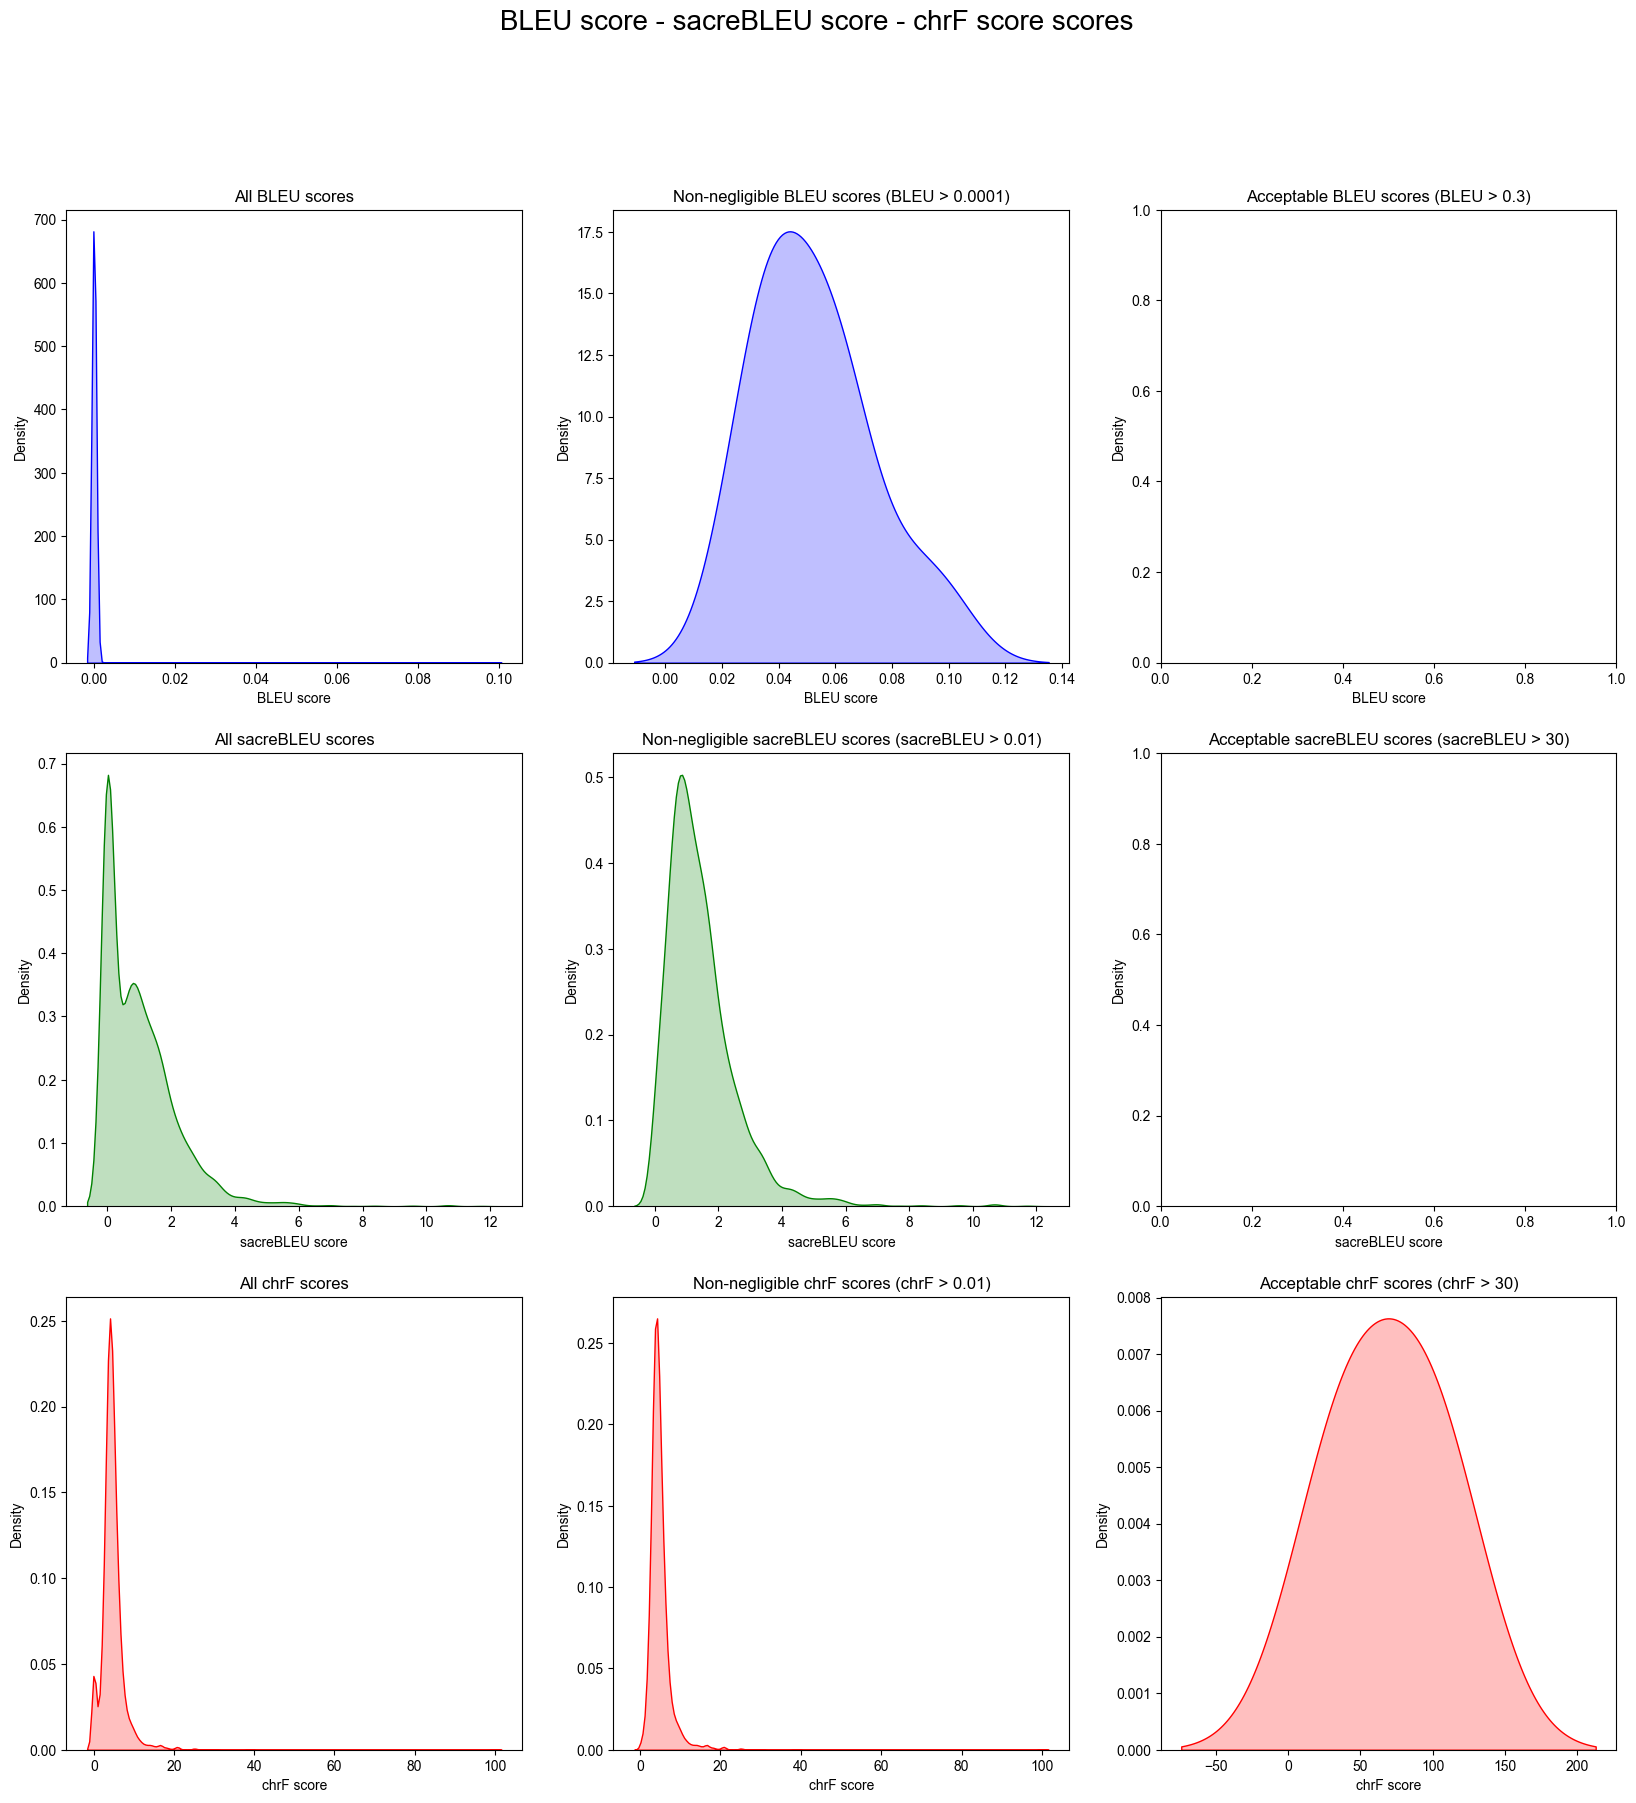

In [18]:
bleu_classic_scores = bleu_scores_df[bleu_scores_df['metric'] == 'classic']['score']
sacrebleu_scores    = bleu_scores_df[bleu_scores_df['metric'] == 'sacrebleu']['score']
chrf_scores         = bleu_scores_df[bleu_scores_df['metric'] == 'chrf']['score']
scores = [bleu_classic_scores, sacrebleu_scores, chrf_scores]

acceptance_thresholds = [0.3, 30, 30]
epsilons = [0.0001, 0.01, 0.01]
save_path = os.path.join(CURRENT_RESULTS_FOLDER, 'bleu_scores.png')

bleu_titles = ['All BLEU scores', f'Non-negligible BLEU scores (BLEU > {epsilons[0]})', f'Acceptable BLEU scores (BLEU > {acceptance_thresholds[0]})']
sacrebleu_titles = ['All sacreBLEU scores', f'Non-negligible sacreBLEU scores (sacreBLEU > {epsilons[1]})', f'Acceptable sacreBLEU scores (sacreBLEU > {acceptance_thresholds[1]})']
chrf_titles = ['All chrF scores', f'Non-negligible chrF scores (chrF > {epsilons[2]})', f'Acceptable chrF scores (chrF > {acceptance_thresholds[2]})']
titles = [bleu_titles, sacrebleu_titles, chrf_titles]
xlabels = ['BLEU score', 'sacreBLEU score', 'chrF score']
colors = ['blue', 'green', 'red']

plot_thresholded_scores(scores, titles, xlabels, acceptance_thresholds, epsilons, save_path=save_path, colors=colors)

### **Best BLEU scores**

In [19]:
def get_ordered_score_indexes(scores, best=True, limit=3):
    return sorted(range(len(scores)), key=lambda i: scores[i], reverse=best)[:limit]

def show_translations(indexes, reference_source, reference_destination, decoded_outputs, save_path=None):

    printed_messages = []
    for idx in indexes:
        reference_destination_tokens = set(reference_destination[idx].strip().split(' '))
        decoded_output_tokens = set(decoded_outputs[idx].strip().split(' '))
        overlapping_words = reference_destination_tokens.intersection(decoded_output_tokens)
        
        printed_message = [
            f'Index: {idx}',
            f'Reference source: {reference_source[idx][:-1]}',
            f'Reference destination: {reference_destination[idx][:-1]}',
            f'Decoded output: {decoded_outputs[idx]}',
            f'Reference destination tokens: {reference_destination_tokens}',
            f'Decoded output tokens: {decoded_output_tokens}',
            f'Overlapping words: {overlapping_words}',
            '------------------'
        ]
        printed_messages.append('\n'.join(printed_message))

    for message in printed_messages:
        print(message)

    if save_path is not None:
        with open(save_path, 'w', encoding='utf-8') as f:
            f.write('\n\n'.join(printed_messages))

In [20]:
best_indexes = get_ordered_score_indexes(list(bleu_classic_scores), best=True, limit=10)
save_dir = os.path.join(CURRENT_RESULTS_FOLDER, 'best_translations.txt')
show_translations(best_indexes, reference_source_gn, reference_destination_es, decoded_outputs, save_path=save_dir)

Index: 4856
Reference source: Ojoja, peteĩ equipo técnico Paraguái Ñe'ẽnguéra Sãmbyhyha guive, omoakãva Ypykuéra Ñe'ẽ Ñeñongatu ha Ñemombarete Moakãharapavẽ, Nieves Montiel, omba'apohína ko'ã indígena ndive comunidad pe, jahechápe toñeñongatu ha taimbaretejey iñe'ẽnguéra, itenondéva indígena ñe'ẽ ikangyetevéva apytépe ñane retãme.
Reference destination: Al mismo tiempo, un equipo técnico de la Secretaría de Políticas Lingũísticas liderado por la Directora General de Documentación y Promoción de Lenguas Indígenas, Nieves Montiel, está realizando en la comunidad trabajos de campo en las líneas de documentación y revitalización de la lengua guaná, catalogada en serio riesgo de extinción.
Decoded output: La Ministra de la SPL y fue acompañada de la Directora General de Documentación y de la Dirección General de Educación De toda la Dirección General de Educación

Reference destination tokens: {'un', 'liderado', 'Al', 'de', 'está', 'revitalización', 'comunidad', 'Directora', 'lengua', 'Ling

In [21]:
best_indexes = get_ordered_score_indexes(list(sacrebleu_scores), best=True, limit=10)
show_translations(best_indexes, reference_source_gn, reference_destination_es, decoded_outputs)

Index: 4692
Reference source: Omopu'ã óga “Casa de la Cultura”
Reference destination: Construyen futura "Casa de la Cultura"
Decoded output: Feliz día de la República

Reference destination tokens: {'la', '"Casa', 'Cultura"', 'de', 'Construyen', 'futura'}
Decoded output tokens: {'día', 'la', 'República', 'Feliz', 'de'}
Overlapping words: {'la', 'de'}
------------------
Index: 886
Reference source: Oipytyvõ hikuái umi familia ysyry okakuaávoa
Reference destination: Asisten a familias tras crecida
Decoded output: Lista se enviará a operar

Reference destination tokens: {'tras', 'crecida', 'Asisten', 'a', 'familias'}
Decoded output tokens: {'Lista', 'operar', 'se', 'a', 'enviará'}
Overlapping words: {'a'}
------------------
Index: 2945
Reference source: Ogueru hetaiterei policía.
Reference destination: Trajeron montón de policías.
Decoded output: Feliz día de la República

Reference destination tokens: {'de', 'policías.', 'Trajeron', 'montón'}
Decoded output tokens: {'día', 'la', 'Repúbli

In [22]:
best_indexes = get_ordered_score_indexes(list(chrf_scores), best=True, limit=10)
#save_dir = os.path.join(CURRENT_RESULTS_FOLDER, 'best_translations.txt')
show_translations(best_indexes, reference_source_gn, reference_destination_es, decoded_outputs, save_path=None)

Index: 3865
Reference source: maitei, mba'éichapa
Reference destination: Hola
Decoded output: Hola y ya no corre

Reference destination tokens: {'Hola'}
Decoded output tokens: {'corre', 'ya', 'Hola', 'no', 'y'}
Overlapping words: {'Hola'}
------------------
Index: 4174
Reference source: Ko’ág̃a meve tetãygua omba’apo hag̃ua Estado-pe oñe’ẽkuaava’erã castellano, katu natekotevẽi guarani;
Reference destination: Hasta la fecha, para ser funcionario público, el ciudadano solamente necesita desempeñarse en castellano, pero no en guaraní .
Decoded output: Ordenar por fecha

Reference destination tokens: {'la', 'guaraní', 'pero', 'ciudadano', 'para', 'solamente', 'fecha,', 'desempeñarse', 'el', 'ser', 'Hasta', 'funcionario', 'público,', 'no', '.', 'en', 'necesita', 'castellano,'}
Decoded output tokens: {'fecha', 'por', 'Ordenar'}
Overlapping words: set()
------------------
Index: 3590
Reference source: emoheñói nde atyrã térã eñembyaty ambuére
Reference destination: Crea tu propio grupo o úne

Curiosidad: En el índice 3488 confunde la palabra "igualdad" con "nosotros"... ¿Casualidad?

In [23]:
worst_indexes = get_ordered_score_indexes(list(bleu_classic_scores), best=False)
show_translations(worst_indexes, reference_source_gn, reference_destination_es, decoded_outputs)

Index: 0
Reference source: ñemosẽ
Reference destination: Expulsar
Decoded output: Pese a 10 de cinco de más de 10 millones de nuestro país donde es parte de una de las ciudades de ciencias humanos para llevar a cabo de febrero

Reference destination tokens: {'Expulsar'}
Decoded output tokens: {'para', 'millones', 'país', 'de', 'una', 'donde', 'cinco', 'nuestro', 'más', 'ciudades', 'febrero', 'cabo', 'humanos', 'llevar', 'las', 'a', 'parte', '10', 'es', 'ciencias', 'Pese'}
Overlapping words: set()
------------------
Index: 5
Reference source: Haipy guaraníme ikatúva oñemboguejy reínte
Reference destination: Obras en guaraní para descargar gratis
Decoded output: De nuestro país acerca de diferencia acerca de todos los días de prensa ya de lo largo de lo referente a los miembros de la soberanía de uno de los vecinos de la Central es de la mitad de lo mismo es parte de lo largo de lo contó con otro antes de 10

Reference destination tokens: {'guaraní', 'Obras', 'para', 'gratis', 'descargar

In [24]:
worst_indexes = get_ordered_score_indexes(list(sacrebleu_scores), best=False)
show_translations(worst_indexes, reference_source_gn, reference_destination_es, decoded_outputs)

Index: 0
Reference source: ñemosẽ
Reference destination: Expulsar
Decoded output: Pese a 10 de cinco de más de 10 millones de nuestro país donde es parte de una de las ciudades de ciencias humanos para llevar a cabo de febrero

Reference destination tokens: {'Expulsar'}
Decoded output tokens: {'para', 'millones', 'país', 'de', 'una', 'donde', 'cinco', 'nuestro', 'más', 'ciudades', 'febrero', 'cabo', 'humanos', 'llevar', 'las', 'a', 'parte', '10', 'es', 'ciencias', 'Pese'}
Overlapping words: set()
------------------
Index: 5
Reference source: Haipy guaraníme ikatúva oñemboguejy reínte
Reference destination: Obras en guaraní para descargar gratis
Decoded output: De nuestro país acerca de diferencia acerca de todos los días de prensa ya de lo largo de lo referente a los miembros de la soberanía de uno de los vecinos de la Central es de la mitad de lo mismo es parte de lo largo de lo contó con otro antes de 10

Reference destination tokens: {'guaraní', 'Obras', 'para', 'gratis', 'descargar

### **¿What about the missing line?**

In [25]:
def plot_values_by_index(title, values, color=None):
    sns.set_style('darkgrid')
    x = list(range(len(values)))
    y = values
    plt.title(title)
    plt.plot(x, y, color=color)
    plt.show()

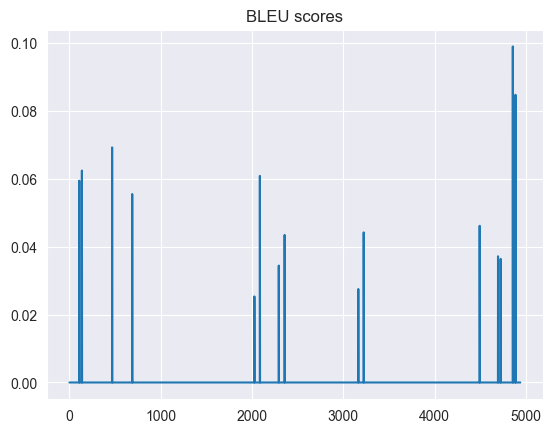

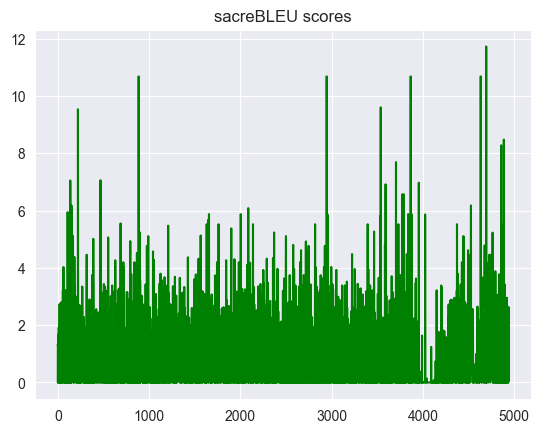

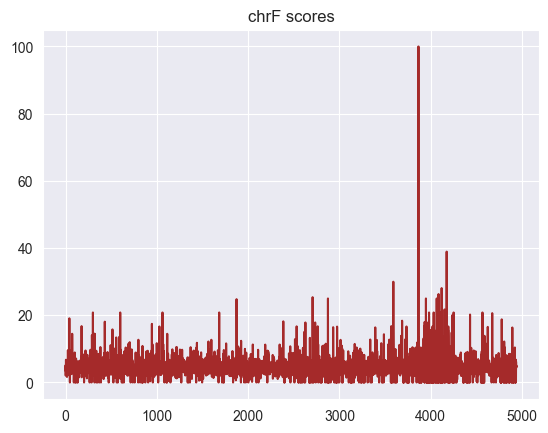

In [26]:
plot_values_by_index('BLEU scores', bleu_classic_scores)
plot_values_by_index('sacreBLEU scores', sacrebleu_scores, color='green')
plot_values_by_index('chrF scores', chrf_scores, color='brown')

Nothing seems to indicate that the missing line is causing problems...

Also, there seems to be considerable agreement between the classic BLEU score and SacreBLEU (except from low scores).